# LENET MODEL for Classification with PyTorch

เราจะมาลองสร้าง LENET MODEL ซึ่งเป็น CNN model ตัวแรกๆ ขนาดใหญ่ขึ้นมาจาก simple CNN อีกหน่อย ใช้สำหรับงาน classification

ขั้นตอนในการสร้างโมเดล
1. data exploration
2. data correction
3. data preparation
4. load data
5. define model architecture
6. train model
7. K-fold cross validation
8. visualize feature map
9. mode evaluation

In [1]:
import torch.nn as nn
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader,SubsetRandomSampler
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import copy
import cv2
import os
import matplotlib.pyplot as plt
from glob import glob
from sklearn.model_selection import train_test_split
import shutil
from PIL import ImageFile
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import classification_report
ImageFile.LOAD_TRUNCATED_IMAGES = True

# DATA EXPLORATION

## Section 1: Exploring Image Data




In [2]:
!curl -L -o train_set.zip https://github.com/NextGen-AI-Camp/curriculum/releases/download/CNN2-Exercise-Dataset/train_set.zip
!curl -L -o test_set.zip https://github.com/NextGen-AI-Camp/curriculum/releases/download/CNN2-Exercise-Dataset/test_set.zip
!unzip -o  train_set.zip
!unzip -o  test_set.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  189M  100  189M    0     0  61.2M      0  0:00:03  0:00:03 --:--:-- 90.2M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 51.9M  100 51.9M    0     0  29.0M      0  0:00:01  0:00:01 --:--:-- 56.6M
Archive:  train_set.zip
   creating: train/BooPadPongali/
  inflating: train/BooPadPongali/002.jpg  
  inflating: train/BooPadPongali/003.jpg  
  inflating: train/BooPadPongali/004.jpg  
  inflating: train/BooPadPongali/005.jpg  
  inflating: train/BooPadPongali/006.jpg  
  inflating: train/BooPadPongali/007.jpg  
  inflating: train/BooPadPongali/008.jpg  
  inflati

## Utility Functions for Data Exploration



In [3]:
# Utility
def copy_files_to_new_folders(original_dataset_dir, train_files, test_files, val_files):
    splits = [('train', train_files), ('test', test_files), ('val', val_files)]
    for split_name, files in splits:
        split_dir = os.path.join(original_dataset_dir, split_name)
        for file_path in files:
            class_name = os.path.basename(os.path.dirname(file_path))
            new_file_path = os.path.join(split_dir, class_name, os.path.basename(file_path))
            os.makedirs(os.path.dirname(new_file_path), exist_ok=True)
            shutil.copyfile(file_path, new_file_path)

def get_file_paths(dataset_dir):
    subdirs = [os.path.join(dataset_dir, d) for d in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, d))]

    file_paths = []
    for subdir in subdirs:
        file_paths.extend(glob(os.path.join(subdir, '*')))

    return file_paths

def split_dataset(file_paths, train_size=0.7, val_size=0.2,seed=42):
    train_files, test_files = train_test_split(file_paths, train_size=train_size, random_state=seed)
    train_files, val_files = train_test_split(train_files, test_size=val_size, random_state=seed)
    return train_files, test_files, val_files

def count_classes(file_list):
    class_counts = {}
    for file_path in file_list:
        class_name = os.path.basename(os.path.dirname(file_path))
        class_counts[class_name] = class_counts.get(class_name, 0) + 1
    return class_counts

def center_crop_image(img, target_size=(64, 64)):
    new_dim = target_size[0] + 3

    if img.shape[1] > img.shape[0]:
        aspect_ratio = img.shape[1] / img.shape[0]
        new_width = int(new_dim * aspect_ratio)
        resized_img = cv2.resize(img, (new_width, new_dim))
    else:
        aspect_ratio = img.shape[1] / img.shape[0]
        new_height = int(new_dim / aspect_ratio)
        resized_img = cv2.resize(img, (new_dim, new_height))

    width, height = resized_img.shape[1], resized_img.shape[0]
    crop_width = min(target_size[0], width)
    crop_height = min(target_size[1], height)
    mid_x, mid_y = width // 2, height // 2
    cw2, ch2 = crop_width // 2, crop_height // 2

    cropped_img = resized_img[mid_y - ch2: mid_y + ch2, mid_x - cw2: mid_x + cw2]

    return cropped_img

def prepare_data(dataset_dir,seed=42):
    file_paths = get_file_paths(dataset_dir)
    train_files, test_files, val_files = split_dataset(file_paths, train_size=0.7, val_size=0.2,seed=seed)
    print("Training files:", len(train_files))
    print("Testing files:", len(test_files))
    print("Validation files:", len(val_files))
    train_counts = count_classes(train_files)
    test_counts = count_classes(test_files)
    val_counts = count_classes(val_files)
    print("Training files per class:", train_counts)
    print("Testing files per class:", test_counts)
    print("Validation files per class:", val_counts)
    return [train_files, test_files, val_files]

def explore(image_paths,center_crop=False):
    dataset_width = []
    dataset_height = []
    dataset_channels = []
    dataset_aspect_ratio = []
    avg_brightness_gray =[]
    avg_brightness_r = []
    avg_brightness_g = []
    avg_brightness_b = []

    for filename in image_paths:
        img = cv2.imread(filename)
        if center_crop:
            img = center_crop_image(img)
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            h, w, c = img.shape
            dataset_width.append(w)
            dataset_height.append(h)
            dataset_channels.append(c)
            dataset_aspect_ratio.append(w / h)
            red = np.mean(img[...,0])
            avg_brightness_r.append(red)
            green = np.mean(img[...,1])
            avg_brightness_g.append(green)
            blue = np.mean(img[...,2])
            avg_brightness_b.append(blue)
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            avg_brightness_gr = np.mean(gray)
            avg_brightness_gray.append(avg_brightness_gr)
    return dataset_width,dataset_height,dataset_channels,dataset_aspect_ratio,avg_brightness_gray,avg_brightness_r,avg_brightness_g,avg_brightness_b

def compute_max_values(datasets):
    max_width = max_height = max_aspect_ratio = max_brightness_gray = max_brightness_rgb = float('-inf')

    for dataset in datasets:
        dataset_width, dataset_height, _, dataset_aspect_ratio, avg_brightness_gray, avg_brightness_r, avg_brightness_g, avg_brightness_b = explore(dataset)

        max_width = max(max_width, max(dataset_width))
        max_height = max(max_height, max(dataset_height))
        max_aspect_ratio = max(max_aspect_ratio, max(dataset_aspect_ratio))
        max_brightness_gray = max(max_brightness_gray, max(avg_brightness_gray))
        max_brightness_rgb = max(max_brightness_rgb, max(avg_brightness_r), max(avg_brightness_g), max(avg_brightness_b))

    return max_width, max_height, max_aspect_ratio, max_brightness_gray, max_brightness_rgb

def summary(dataset_dir,seed,center_crop=False):
    train_files, test_files, val_files = prepare_data(dataset_dir, seed=seed)
    max_len = 0
    for ele in [train_files, test_files, val_files]:
        max_len = max(max_len, len(ele))
    max_width, max_height, max_aspect_ratio, max_brightness_gray, max_brightness_rgb = compute_max_values([train_files, test_files, val_files])

    row_labels = ['Train', 'Test', 'Val']
    fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(10, 8))
    fig.suptitle(f'Dataset Exploration: Train, Test, and Validation Sets\nSEED: {seed}', fontsize=20, weight='bold')
    font_size = 6
    title_font_size = font_size + 2
    for index, dataset in enumerate([train_files, test_files, val_files]):
        dataset_width, dataset_height, _, dataset_aspect_ratio, avg_brightness_gray, avg_brightness_r, avg_brightness_g, avg_brightness_b = explore(dataset,center_crop=center_crop)

        ax[index, 0].scatter(dataset_width, dataset_height, marker='x',)
        ax[index, 0].plot([0, max_width+200], [0, max_width+200], color='red', label='aspect ratio = 1')
        ax[index, 0].legend(fontsize=font_size)
        ax[index, 0].set_xlim([0, max(max_width,max_height)+50])
        ax[index, 0].set_ylim([0, max(max_width,max_height)+50])
        ax[index, 0].tick_params(axis='both', labelsize=font_size)
        ax[index, 0].set_xlabel('Width', fontsize=font_size)
        ax[index, 0].set_ylabel('Height', fontsize=font_size)
        ax[index, 0].set_title('Scatter Plot of Dataset Width and Height', fontsize=font_size)

        ax[index, 1].hist(dataset_aspect_ratio)
        ax[index, 1].set_ylim([0, max_len+50])
        ax[index, 1].tick_params(axis='both', labelsize=font_size)
        ax[index, 1].set_xlabel('Aspect Ratio', fontsize=font_size)
        ax[index, 1].set_ylabel('Frequency', fontsize=font_size)
        ax[index, 1].set_title('Aspect Ratio Distribution', fontsize=font_size)

        ax[index, 2].boxplot(avg_brightness_gray, vert=False, patch_artist=True, showmeans=True)
        ax[index, 2].set_xlim([0, max_brightness_gray+50])
        ax[index, 2].tick_params(axis='both', labelsize=font_size)
        ax[index, 2].set_xlabel("Average Brightness", fontsize=font_size)
        ax[index, 2].set_title("Box Plot of Average Brightness for Images", fontsize=font_size)

        ax[index, 3].boxplot([avg_brightness_r, avg_brightness_g, avg_brightness_b], vert=False, patch_artist=True, showmeans=True)
        ax[index, 3].set_xlim([0, max_brightness_rgb+50])
        ax[index, 3].tick_params(axis='both', labelsize=font_size)
        ax[index, 3].set_xlabel("Average Brightness", fontsize=font_size)
        ax[index, 3].set_yticklabels(['R', 'G', 'B'], fontsize=font_size)
        ax[index, 3].set_title("Box Plot of Average Brightness for Images", fontsize=font_size)

        ax[index, 0].text(-0.5, 0.5, row_labels[index],  fontsize=font_size, weight='bold', transform=ax[index, 0].transAxes)

    plt.tight_layout()
    plt.show()

Training files: 580
Testing files: 311
Validation files: 145
Training files per class: {'FriedKale': 180, 'MassamanGai': 138, 'BooPadPongali': 182, 'PadPakBung': 80}
Testing files per class: {'MassamanGai': 72, 'FriedKale': 94, 'BooPadPongali': 99, 'PadPakBung': 46}
Validation files per class: {'PadPakBung': 20, 'MassamanGai': 37, 'BooPadPongali': 51, 'FriedKale': 37}


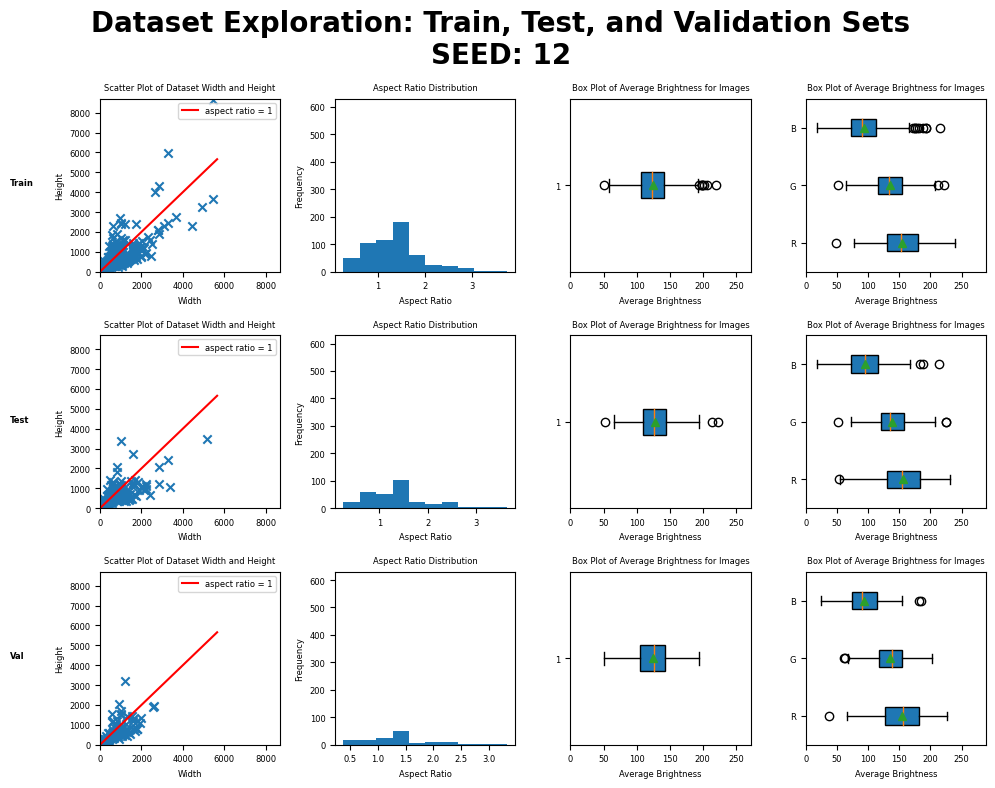

Training files: 580
Testing files: 311
Validation files: 145
Training files per class: {'BooPadPongali': 188, 'PadPakBung': 83, 'FriedKale': 178, 'MassamanGai': 131}
Testing files per class: {'FriedKale': 96, 'MassamanGai': 69, 'BooPadPongali': 96, 'PadPakBung': 50}
Validation files per class: {'FriedKale': 37, 'PadPakBung': 13, 'MassamanGai': 47, 'BooPadPongali': 48}


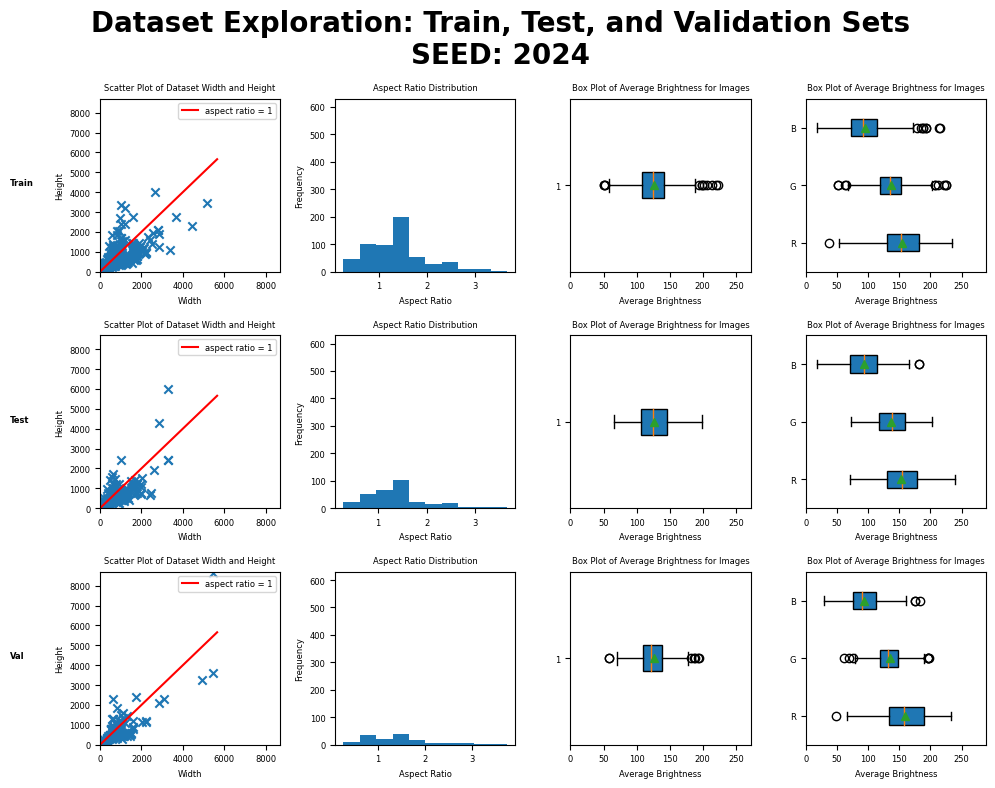

Training files: 580
Testing files: 311
Validation files: 145
Training files per class: {'BooPadPongali': 173, 'PadPakBung': 84, 'MassamanGai': 141, 'FriedKale': 182}
Testing files per class: {'PadPakBung': 39, 'FriedKale': 88, 'MassamanGai': 73, 'BooPadPongali': 111}
Validation files per class: {'PadPakBung': 23, 'BooPadPongali': 48, 'FriedKale': 41, 'MassamanGai': 33}


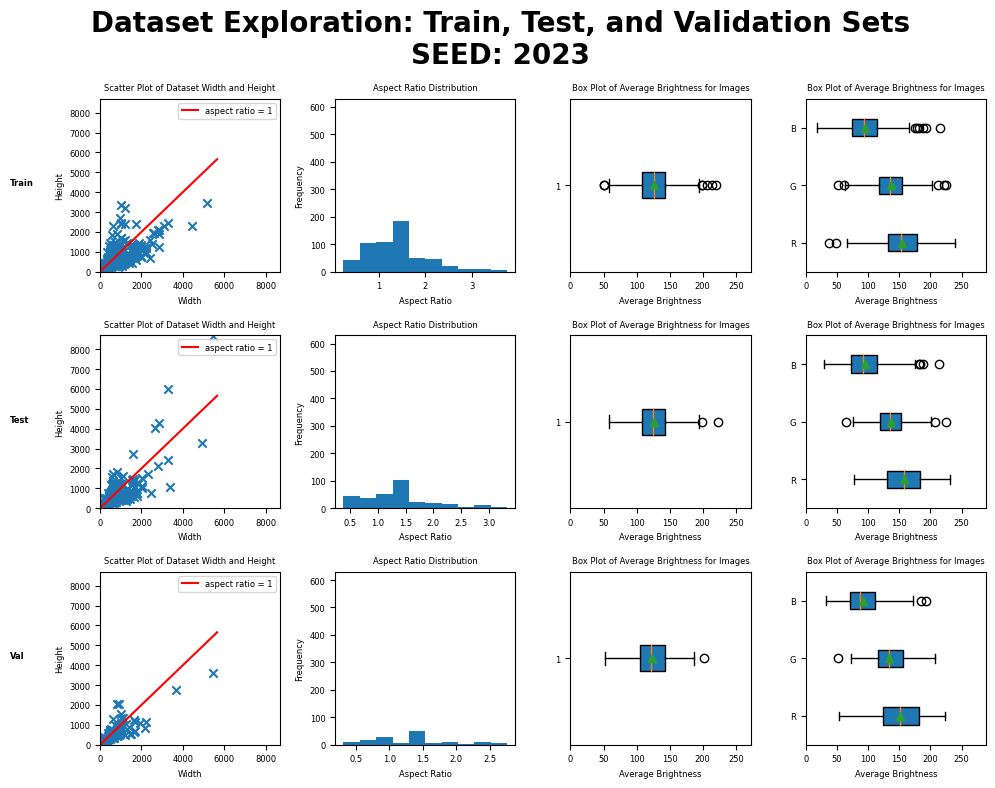

In [4]:
dataset_dir = "/content/train"
summary(dataset_dir,12)
summary(dataset_dir,2024)
summary(dataset_dir,2023)


Training files: 580
Testing files: 311
Validation files: 145
Training files per class: {'FriedKale': 180, 'MassamanGai': 138, 'BooPadPongali': 182, 'PadPakBung': 80}
Testing files per class: {'MassamanGai': 72, 'FriedKale': 94, 'BooPadPongali': 99, 'PadPakBung': 46}
Validation files per class: {'PadPakBung': 20, 'MassamanGai': 37, 'BooPadPongali': 51, 'FriedKale': 37}


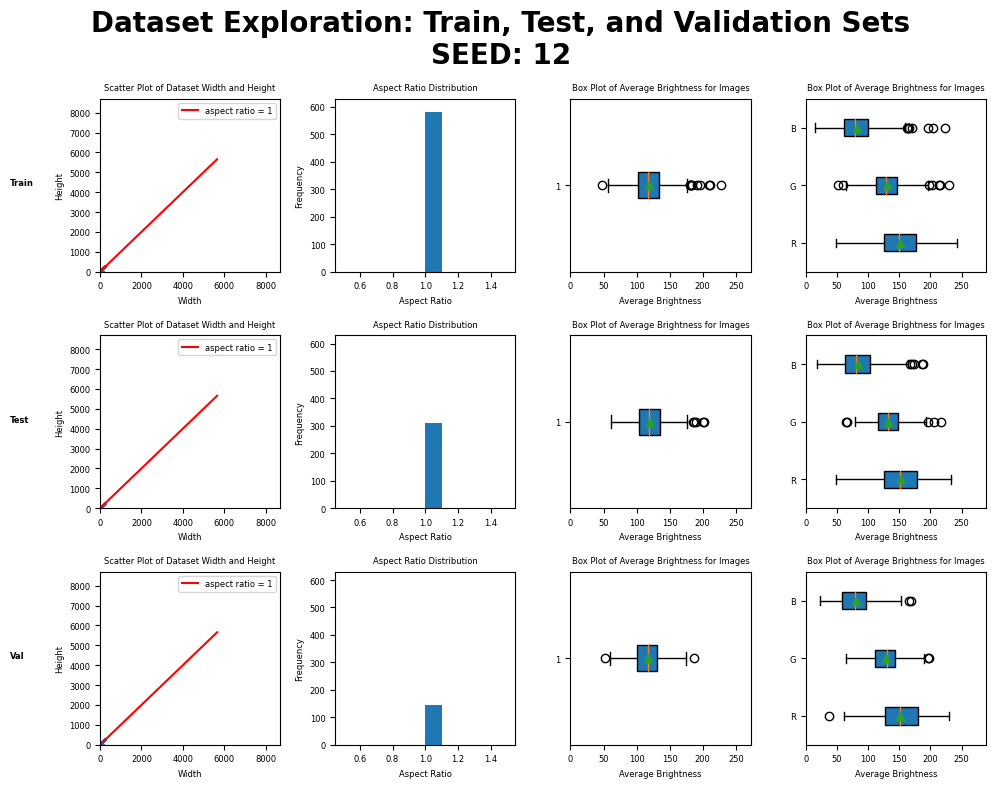

In [5]:
dataset_dir = "/content/train"
summary(dataset_dir,12,center_crop=True)

# DATA CORRECTION
- ASPECT RATIO → CENTER CROP


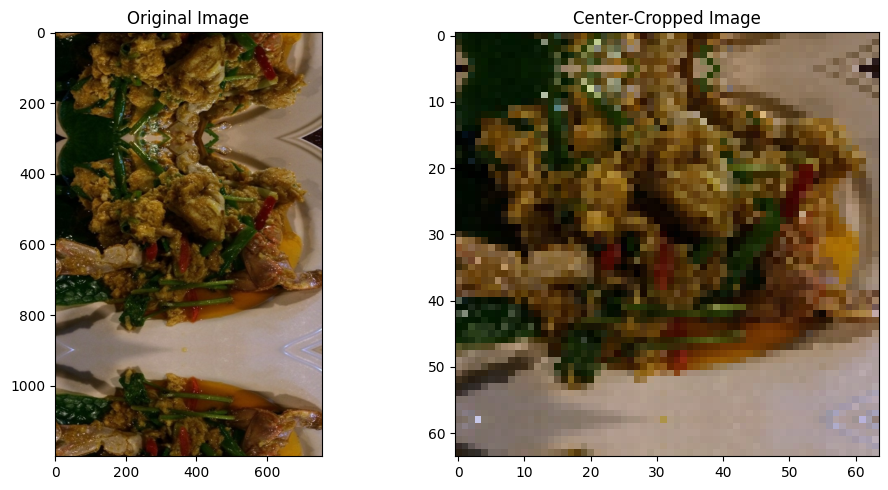

In [6]:
og_img = cv2.imread('/content/train/BooPadPongali/002.jpg')
og_img = cv2.cvtColor(og_img,cv2.COLOR_BGR2RGB)
img = center_crop_image(og_img,(64,64))
ig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Display the original image
ax[0].imshow(og_img)
ax[0].set_title('Original Image')

# Display the center-cropped image
ax[1].imshow(img)
ax[1].set_title('Center-Cropped Image')


plt.tight_layout()
plt.show()

In [7]:
seed = 12
dataset_dir = "/content/train"
train_files, test_files, val_files = prepare_data(dataset_dir, seed=seed)

copy_files_to_new_folders(f'/content/seed{seed}', train_files, test_files, val_files)

Training files: 580
Testing files: 311
Validation files: 145
Training files per class: {'FriedKale': 180, 'MassamanGai': 138, 'BooPadPongali': 182, 'PadPakBung': 80}
Testing files per class: {'MassamanGai': 72, 'FriedKale': 94, 'BooPadPongali': 99, 'PadPakBung': 46}
Validation files per class: {'PadPakBung': 20, 'MassamanGai': 37, 'BooPadPongali': 51, 'FriedKale': 37}


---

# DATA PREPARATION
เป็นขั้นตอนสำคัญในการเตรียมข้อมูลเพื่อให้ได้ข้อมูลที่ดีและมีความหลากหลายเพียงพอ ช่วยให้โมเดลสามารถเรียนรู้และทำนายได้แม่นยำมากขึ้น หนึ่งในกระบวนการสำคัญในขั้นตอนการเตรียมข้อมูลคือ Data Augmentation

### Data Augmentation


In [8]:
def load_data(path,is_test=False):
    torch.manual_seed(4912)

    if is_test:
        transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((64, 64)),
        ])
        dataset = ImageFolder(path, transform=transform)

    else:
        transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((66, 66)),
        transforms.Pad(65, padding_mode='reflect'),
        transforms.RandomAffine(degrees=15, translate=(0.05, 0.05),scale=(0.8, 1.2), shear=10),
        transforms.CenterCrop(64),
        ])
        dataset = ImageFolder(path, transform=transform)
    class_names = dataset.classes
    print("class_names",class_names)
    data_loader = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=16, pin_memory=True)

    print("📃Dataset:")
    class_counts_train = [0] * len(class_names)
    for _, target in dataset:
        class_counts_train[target] += 1

    for class_name, class_count in zip(class_names, class_counts_train):
        print(f"\tNumber of images in class {class_name}: {class_count}")

    print(f"\tNumber of samples: {len(dataset)}")

    return dataset

In [9]:
train_dataset = load_data('/content/seed12/train')
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=16, pin_memory=True)
test_dataset = load_data('/content/seed12/test',is_test=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True, num_workers=16, pin_memory=True)
val_dataset = load_data('/content/seed12/val',is_test=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=True, num_workers=16, pin_memory=True)


class_names ['BooPadPongali', 'FriedKale', 'MassamanGai', 'PadPakBung']
📃Dataset:


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


	Number of images in class BooPadPongali: 182
	Number of images in class FriedKale: 180
	Number of images in class MassamanGai: 138
	Number of images in class PadPakBung: 80
	Number of samples: 580
class_names ['BooPadPongali', 'FriedKale', 'MassamanGai', 'PadPakBung']
📃Dataset:
	Number of images in class BooPadPongali: 99
	Number of images in class FriedKale: 94
	Number of images in class MassamanGai: 72
	Number of images in class PadPakBung: 46
	Number of samples: 311
class_names ['BooPadPongali', 'FriedKale', 'MassamanGai', 'PadPakBung']
📃Dataset:
	Number of images in class BooPadPongali: 51
	Number of images in class FriedKale: 37
	Number of images in class MassamanGai: 37
	Number of images in class PadPakBung: 20
	Number of samples: 145


In [10]:
def imshow_grid(images, labels, class_names):
    num_images = len(images)
    num_rows = int(np.ceil(np.sqrt(num_images)))
    num_cols = int(np.ceil(num_images / num_rows))

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 6),dpi=100)
    for i, ax in enumerate(axes.flat):
        if i < num_images:
            image = images[i].permute(1, 2, 0)
            label = labels[i].item()
            ax.imshow(torch.clamp(image,0,1))
            ax.set_title(class_names[label])
            ax.axis('off')
        else:
            ax.axis('off')
    plt.tight_layout()
    plt.show()

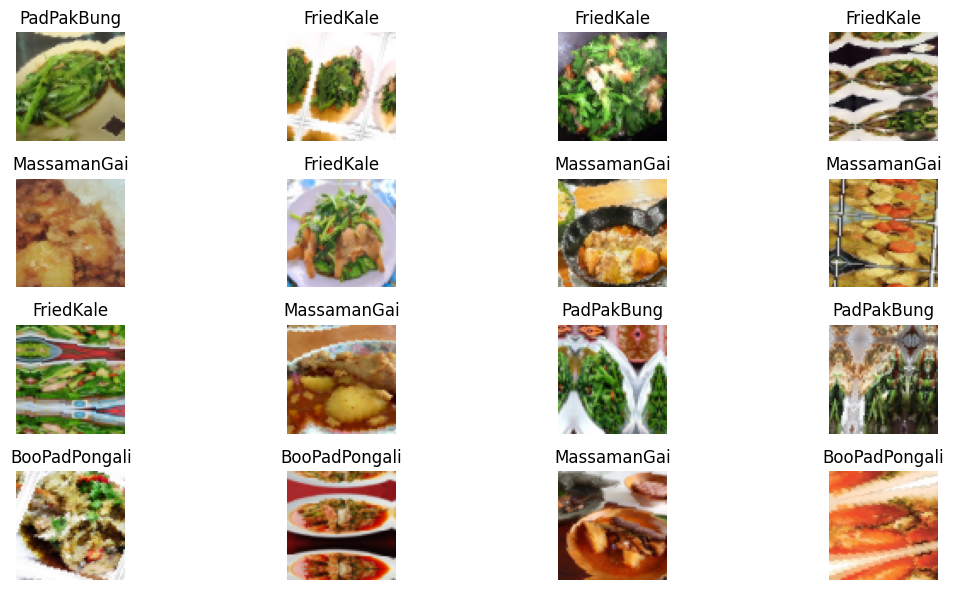

In [11]:
class_names = ['BooPadPongali', 'FriedKale', 'MassamanGai', 'PadPakBung']
batch, labels = next(iter(train_loader))
imshow_grid(batch, labels, class_names)

# MODEL ARCHITECTURE
## LeNet Model Architecture

![lenet.jpg](https://github.com/NextGen-AI-Camp/curriculum/blob/main/Week%235/CNN%232/asset/lenet.jpg?raw=true)

https://www.naukri.com/code360/library/lenet-5

LeNet เป็นหนึ่งในสถาปัตยกรรมของ Convolutional Neural Network (CNN) ที่ได้รับความนิยมในการจดจำภาพ โดย LeNet ถูกพัฒนาขึ้นโดย Yann LeCun และคณะในปี 1998 สำหรับการจำแนกตัวเลขที่เขียนด้วยลายมือ (MNIST dataset) สถาปัตยกรรมของ LeNet ประกอบด้วยเลเยอร์หลายชั้นซึ่งทำงานร่วมกันเพื่อแยกคุณสมบัติที่มีความสำคัญจากภาพ

### โครงสร้างของ LeNet

LeNet ประกอบด้วยเลเยอร์หลักดังนี้:
1. **Convolutional Layer 1 (C1)**: ใช้ kernel weights ขนาด 5x5 จำนวน 6 ตัว ทำให้ได้ 6 feature maps ขนาด 28x28 จะสังเกตว่าขนาดของผลลัพธ์ลดลงจากขนาดภาพอินพุท เนื่องจากไม่มีการทำ padding ก่อนทำ convolution ในตัวกรอง
2. **Subsampling Layer 1 (S2)**: ใช้การทำ Average Pooling ขนาด 2x2 ลดขนาด feature maps ลงครึ่งหนึ่งเป็น 14x14
3. **Convolutional Layer 2 (C3)**: ใช้ตัวกรองขนาด 5x5 จำนวน 16 ตัว ทำให้ได้ 16 feature maps ขนาด 10x10 (no padding เช่นเดียวกันกับ C1)
4. **Subsampling Layer 2 (S4)**: ใช้การทำ Average Pooling ขนาด 2x2 ลดขนาด feature maps ลงครึ่งหนึ่งเป็น 5x5
5. **Fully Connected Layer 1 (F5)**: แปลง feature maps เป็น vector และเชื่อมต่อเข้ากับ Neuron จำนวน 120 ตัว
6. **Fully Connected Layer 2 (F6)**: เชื่อมต่อ Neuron จำนวน 120 ตัวไปยัง Neuron จำนวน 84 ตัว
7. **Output Layer**: ใช้ Softmax เพื่อจำแนก 10 คลาส (สำหรับ MNIST)

โดยในการจำลองโมเดลใน code ด้านล่างนี้ จะใช้ภาพอินพุทขนาด 64x64 เพื่อให้วัตถุไม่เล็กจนเกินไป
### ผลกระทบของจำนวนเลเยอร์และขนาดของ output channel

**จำนวนเลเยอร์และขนาดของ output channel** มีผลกระทบต่อประสิทธิภาพของโมเดลอย่างมาก เลเยอร์ที่มากขึ้นและขนาดของ output channel ในแต่ละ Layer ที่มากขึ้นสามารถช่วยให้โมเดลสามารถแยกคุณสมบัติที่ซับซ้อนจากภาพได้ดีขึ้น แต่ในขณะเดียวกันก็อาจทำให้โมเดลมีความซับซ้อนมากขึ้นและต้องใช้ทรัพยากรในการคำนวณมากขึ้นด้วย

- **เลเยอร์เริ่มต้นควรมีขนาดเล็กกว่าหรือใหญ่กว่าเลเยอร์ต่อมาหรือไม่?** เลเยอร์เริ่มต้นควรมีขนาดเล็กกว่าเลเยอร์ต่อมา เหตุผลคือเลเยอร์เริ่มต้นจะทำการตรวจจับคุณสมบัติพื้นฐานเช่น ขอบ เส้น และรูปทรงง่ายๆ ในขณะที่เลเยอร์ต่อมาจะทำการตรวจจับคุณสมบัติที่ซับซ้อนมากขึ้น เช่น การรวมกันของรูปแบบพื้นฐานจากเลเยอร์ก่อนหน้า เพื่อประกอบเป็นโครงสร้างของวัตถุ ขนาดของ output channel ในเลเยอร์ต่อมาจึงควรเพิ่มขึ้นเพื่อให้สามารถจับคุณสมบัติที่ซับซ้อนได้มากขึ้น ตัวอย่างเช่น ใน LENET model ขนาดของ output channels หรือ convolutional nodes ในเลเยอร์แรกเริ่มจาก 6 channels ไปเป็น 16 channels ในเลเยอร์ที่สอง การเพิ่มขึ้นของจำนวน channel นี้จะช่วยให้โมเดลสามารถแยกคุณสมบัติที่ซับซ้อนได้มากขึ้น เมื่อผ่านเลเยอร์ไป

### เหตุผลที่โมเดลมีเลเยอร์ subsampling เช่น Average / Max Pooling

การมีเลเยอร์ subsampling เช่น Average / Max Pooling มีความสำคัญใน CNN สำหรับการลดขนาดเชิงพื้นที่ของแผนที่คุณลักษณะ การลดขนาดนี้ช่วยใน:
   - **การลดมิติการประมวลผล**: ลดภาระการคำนวณและการใช้หน่วยความจำ
   - **เทคนิคการประมวลผลแบบพีระมิด**: คล้ายกับเทคนิคการสร้างพีระมิดภาพ โดยการปรับลดขนาดภาพเพื่อช่วยลดขนาดวัตถุ ทำให้สามารถตรวจจับวัตถุที่มีขนาดใหญ่ขึ้นได้ด้วยตัวกรองหรือ Kernel weights ขนาดเท่าเดิม   ช่วยให้โมเดลสามารถประมวลผลคุณลักษณะที่มีความละเอียดและขนาดที่แตกต่างกันได้ โดยไม่เสียเวลาประมวลผลมาก นี่เป็นประโยชน์โดยเฉพาะในการรับรู้วัตถุในขนาดและตำแหน่งที่แตกต่างกันภายในภาพ
   - **การยืดหยุ่นต่อการเปลี่ยนแปลง**: การสรุปคุณลักษณะเชิงสถิติ เช่น Average/Max pooling ในพื้นที่ย่อย ช่วยให้ลดผลกระทบต่อการเปลี่ยนแปลงในพื้นที่ย่อยนั้น และช่วยให้โมเดลความทนทานต่อการแปลและการบิดเบือนเล็กน้อยในภาพ

โดยสรุป สถาปัตยกรรม LeNet ถูกออกแบบด้วยการเพิ่มจำนวน output channels อย่างค่อยเป็นค่อยไปและการลดขนาดของแผนที่คุณลักษณะเพื่อจับคุณลักษณะที่ซับซ้อนได้อย่างมีประสิทธิภาพ การใช้หลากหลายเลเยอร์ช่วยให้โมเดลจัดการกับภาพที่มีความละเอียดและขนาดที่แตกต่างกันได้ ซึ่งช่วยเพิ่มความทนทานและประสิทธิภาพของโมเดล

### เหตุผลการไม่ใส่ Activation Function ที่ Output Node สำหรับปัญหา Multiclass Classification

สำหรับปัญหา Multi-class classification เราเลือกใช้ Loss เป็น
nn.CrossEntropyLoss ใน PyTorch ซึ่งต้องการนำเข้าค่า output logits โดยมีฟังก์ชัน softmax และ negative log-likelihood รวมไว้ภายใน โดย Softmax: จะทำการแปลง logits เป็นความน่าจะเป็นให้กับ Negative Log-Likelihood Loss เพื่อเลี่ยงปัญหาจาก floating point precision และโอการการเกิด underflow หรือ overflow error.


In [47]:
import torch
import torch.nn as nn

class FoodFounder(nn.Module):
    def __init__(self, input_size=(3, 64, 64)):
        super(FoodFounder, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=input_size[0], out_channels=18, kernel_size=5, stride=1, padding=2)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=18, out_channels=8, kernel_size=5, stride=1, padding=2)
        self.relu2 = nn.ReLU()
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout(0.25)

        self.conv3 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=5, stride=1, padding=0)
        self.relu3 = nn.ReLU()
        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.dropout2 = nn.Dropout(0.25)

        self.flatten = nn.Flatten()

        self.fc1 = nn.Linear(self._get_input_size_fc1(input_size), 120)
        self.relu4 = nn.ReLU()
        self.dropout3 = nn.Dropout(0.5)

        self.fc2 = nn.Linear(120, 84)
        self.relu5 = nn.ReLU()
        self.dropout4 = nn.Dropout(0.5)

        self.fc3 = nn.Linear(84, 4)

    def _get_input_size_fc1(self, input_shape):
        with torch.no_grad():
            x = torch.zeros(1, *input_shape)
            x = self.conv1(x)
            x = self.relu1(x)
            x = self.conv2(x)
            x = self.relu2(x)
            x = self.pool1(x)
            x = self.dropout1(x)

            x = self.conv3(x)
            x = self.relu3(x)
            x = self.pool2(x)
            x = self.dropout2(x)

            x = self.flatten(x)
        return x.size(1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool1(x)
        x = self.dropout1(x)

        x = self.conv3(x)
        x = self.relu3(x)
        x = self.pool2(x)
        x = self.dropout2(x)

        x = self.flatten(x)

        x = self.fc1(x)
        x = self.relu4(x)
        x = self.dropout3(x)

        x = self.fc2(x)
        x = self.relu5(x)
        x = self.dropout4(x)

        x = self.fc3(x)
        return x


## Train
### กระบวนการฝึกโมเดล


In [48]:
def train(model, opt, loss_fn, train_loader, test_loader, epochs=10, checkpoint_path=None, device='cpu'):
    print("🤖Training on", device)
    model = model.to(device)

    history = {
        'train_loss': [],
        'train_acc': [],
        'test_loss': [],
        'test_acc': []
    }

    for epoch in range(epochs):
        model.train()
        train_bar = tqdm(train_loader, desc=f'🚀Training Epoch [{epoch+1}/{epochs}]', unit='batch')

        total_train_loss = 0
        total_train_correct = 0

        for images, labels in train_bar:
            images = images.to(device)
            labels = labels.to(device)

            opt.zero_grad()
            output = model(images)
            loss = loss_fn(output, labels)
            loss.backward()
            opt.step()

            total_train_loss += loss.item()
            predicted = torch.argmax(nn.functional.softmax(output, dim=1), dim=1)
            total_train_correct += (predicted == labels).sum().item()

            train_bar.set_postfix(loss=loss.item())

        avg_train_loss = total_train_loss / len(train_loader)
        avg_train_acc = total_train_correct / len(train_loader.dataset)

        history['train_loss'].append(avg_train_loss)
        history['train_acc'].append(avg_train_acc)

        model.eval()
        test_bar = tqdm(test_loader, desc='📄Testing', unit='batch')

        total_test_loss = 0
        total_test_correct = 0

        with torch.no_grad():
            for images, labels in test_bar:
                images = images.to(device)
                labels = labels.to(device)

                output = model(images)
                loss = loss_fn(output, labels)

                total_test_loss += loss.item()
                predicted = torch.argmax(nn.functional.softmax(output, dim=1), dim=1)
                total_test_correct += (predicted == labels).sum().item()

                test_bar.set_postfix(loss=loss.item())

        avg_test_loss = total_test_loss / len(test_loader)
        avg_test_acc = total_test_correct / len(test_loader.dataset)

        history['test_loss'].append(avg_test_loss)
        history['test_acc'].append(avg_test_acc)

        print(f"Summary :")
        print(f"\tTrain \tavg_loss: {avg_train_loss:.4f} \t| avg_acc: {avg_train_acc:.4f}")
        print(f"\tTest \tavg_loss: {avg_test_loss:.4f} \t| avg_acc: {avg_test_acc:.4f}")
        print()

        if checkpoint_path:
            torch.save(model.state_dict(), f"{checkpoint_path}_epoch_{epoch+1}.pth")

    return history


🤖 Training on cuda
🤖Training on cuda


🚀Training Epoch [1/100]:   0%|          | 0/37 [00:00<?, ?batch/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
📄Testing: 100%|██████████| 20/20 [00:01<00:00, 10.05batch/s, loss=1.33]


Summary :
	Train 	avg_loss: 1.3664 	| avg_acc: 0.2621
	Test 	avg_loss: 1.3368 	| avg_acc: 0.3923



📄Testing: 100%|██████████| 20/20 [00:02<00:00,  9.97batch/s, loss=1.04]


Summary :
	Train 	avg_loss: 1.3191 	| avg_acc: 0.3155
	Test 	avg_loss: 1.1595 	| avg_acc: 0.4952



📄Testing: 100%|██████████| 20/20 [00:01<00:00, 10.17batch/s, loss=1.15]


Summary :
	Train 	avg_loss: 1.1516 	| avg_acc: 0.4810
	Test 	avg_loss: 1.0156 	| avg_acc: 0.5338



📄Testing: 100%|██████████| 20/20 [00:02<00:00,  9.56batch/s, loss=1.32]


Summary :
	Train 	avg_loss: 1.0273 	| avg_acc: 0.4862
	Test 	avg_loss: 1.0601 	| avg_acc: 0.3859



📄Testing: 100%|██████████| 20/20 [00:02<00:00,  9.86batch/s, loss=0.699]


Summary :
	Train 	avg_loss: 0.9478 	| avg_acc: 0.4931
	Test 	avg_loss: 0.8867 	| avg_acc: 0.5691



📄Testing: 100%|██████████| 20/20 [00:02<00:00,  9.26batch/s, loss=0.717]


Summary :
	Train 	avg_loss: 0.9426 	| avg_acc: 0.5379
	Test 	avg_loss: 0.9070 	| avg_acc: 0.4180



📄Testing: 100%|██████████| 20/20 [00:02<00:00,  9.08batch/s, loss=0.768]


Summary :
	Train 	avg_loss: 0.8947 	| avg_acc: 0.5362
	Test 	avg_loss: 0.8380 	| avg_acc: 0.5241



📄Testing: 100%|██████████| 20/20 [00:02<00:00,  9.36batch/s, loss=0.691]


Summary :
	Train 	avg_loss: 0.9038 	| avg_acc: 0.5224
	Test 	avg_loss: 0.8473 	| avg_acc: 0.5691



📄Testing: 100%|██████████| 20/20 [00:02<00:00,  8.83batch/s, loss=0.768]


Summary :
	Train 	avg_loss: 0.9039 	| avg_acc: 0.5483
	Test 	avg_loss: 0.8812 	| avg_acc: 0.5563



📄Testing: 100%|██████████| 20/20 [00:02<00:00,  9.83batch/s, loss=0.897]


Summary :
	Train 	avg_loss: 0.8662 	| avg_acc: 0.5362
	Test 	avg_loss: 0.8475 	| avg_acc: 0.5756



📄Testing: 100%|██████████| 20/20 [00:01<00:00, 10.29batch/s, loss=0.971]


Summary :
	Train 	avg_loss: 0.8260 	| avg_acc: 0.5552
	Test 	avg_loss: 0.8493 	| avg_acc: 0.5466



📄Testing: 100%|██████████| 20/20 [00:01<00:00, 10.45batch/s, loss=0.778]


Summary :
	Train 	avg_loss: 0.8354 	| avg_acc: 0.5707
	Test 	avg_loss: 0.8298 	| avg_acc: 0.5884



📄Testing: 100%|██████████| 20/20 [00:02<00:00,  9.54batch/s, loss=0.745]


Summary :
	Train 	avg_loss: 0.8465 	| avg_acc: 0.5672
	Test 	avg_loss: 0.8483 	| avg_acc: 0.5048



📄Testing: 100%|██████████| 20/20 [00:02<00:00,  9.25batch/s, loss=0.701]


Summary :
	Train 	avg_loss: 0.8096 	| avg_acc: 0.5638
	Test 	avg_loss: 0.7939 	| avg_acc: 0.5788



📄Testing: 100%|██████████| 20/20 [00:01<00:00, 10.48batch/s, loss=0.672]


Summary :
	Train 	avg_loss: 0.8214 	| avg_acc: 0.5517
	Test 	avg_loss: 0.7959 	| avg_acc: 0.5531



📄Testing: 100%|██████████| 20/20 [00:02<00:00,  9.35batch/s, loss=0.645]


Summary :
	Train 	avg_loss: 0.8318 	| avg_acc: 0.5483
	Test 	avg_loss: 0.7969 	| avg_acc: 0.5756



📄Testing: 100%|██████████| 20/20 [00:02<00:00,  9.22batch/s, loss=0.702]


Summary :
	Train 	avg_loss: 0.8458 	| avg_acc: 0.5534
	Test 	avg_loss: 0.8116 	| avg_acc: 0.5691



📄Testing: 100%|██████████| 20/20 [00:02<00:00,  9.74batch/s, loss=0.928]


Summary :
	Train 	avg_loss: 0.8354 	| avg_acc: 0.5500
	Test 	avg_loss: 0.8643 	| avg_acc: 0.5723



📄Testing: 100%|██████████| 20/20 [00:02<00:00,  9.53batch/s, loss=1.02]


Summary :
	Train 	avg_loss: 0.8095 	| avg_acc: 0.5379
	Test 	avg_loss: 0.9252 	| avg_acc: 0.5305



📄Testing: 100%|██████████| 20/20 [00:01<00:00, 10.10batch/s, loss=0.891]


Summary :
	Train 	avg_loss: 0.8609 	| avg_acc: 0.5552
	Test 	avg_loss: 0.7985 	| avg_acc: 0.5788



📄Testing: 100%|██████████| 20/20 [00:01<00:00, 10.02batch/s, loss=0.622]


Summary :
	Train 	avg_loss: 0.8111 	| avg_acc: 0.5897
	Test 	avg_loss: 0.7881 	| avg_acc: 0.5691



📄Testing: 100%|██████████| 20/20 [00:02<00:00,  9.64batch/s, loss=0.674]


Summary :
	Train 	avg_loss: 0.8246 	| avg_acc: 0.5121
	Test 	avg_loss: 0.7865 	| avg_acc: 0.5498



📄Testing: 100%|██████████| 20/20 [00:02<00:00,  9.74batch/s, loss=0.681]


Summary :
	Train 	avg_loss: 0.8055 	| avg_acc: 0.5293
	Test 	avg_loss: 0.8034 	| avg_acc: 0.5595



📄Testing: 100%|██████████| 20/20 [00:02<00:00,  9.82batch/s, loss=0.667]


Summary :
	Train 	avg_loss: 0.8196 	| avg_acc: 0.5724
	Test 	avg_loss: 0.7880 	| avg_acc: 0.5498



📄Testing: 100%|██████████| 20/20 [00:02<00:00,  9.41batch/s, loss=1.09]


Summary :
	Train 	avg_loss: 0.8034 	| avg_acc: 0.5397
	Test 	avg_loss: 0.7781 	| avg_acc: 0.5884



📄Testing: 100%|██████████| 20/20 [00:02<00:00,  8.98batch/s, loss=0.744]


Summary :
	Train 	avg_loss: 0.7837 	| avg_acc: 0.5586
	Test 	avg_loss: 0.8397 	| avg_acc: 0.5595



📄Testing: 100%|██████████| 20/20 [00:02<00:00,  9.16batch/s, loss=0.867]


Summary :
	Train 	avg_loss: 0.7807 	| avg_acc: 0.5879
	Test 	avg_loss: 0.7876 	| avg_acc: 0.6013



📄Testing: 100%|██████████| 20/20 [00:02<00:00,  9.07batch/s, loss=0.632]


Summary :
	Train 	avg_loss: 0.8417 	| avg_acc: 0.5431
	Test 	avg_loss: 0.7725 	| avg_acc: 0.5949



📄Testing: 100%|██████████| 20/20 [00:01<00:00, 10.42batch/s, loss=0.74]


Summary :
	Train 	avg_loss: 0.7835 	| avg_acc: 0.5741
	Test 	avg_loss: 0.8112 	| avg_acc: 0.5756



📄Testing: 100%|██████████| 20/20 [00:02<00:00,  9.64batch/s, loss=0.687]


Summary :
	Train 	avg_loss: 0.7827 	| avg_acc: 0.5621
	Test 	avg_loss: 0.7980 	| avg_acc: 0.5852



📄Testing: 100%|██████████| 20/20 [00:02<00:00,  9.67batch/s, loss=0.708]


Summary :
	Train 	avg_loss: 0.7475 	| avg_acc: 0.5793
	Test 	avg_loss: 0.7817 	| avg_acc: 0.5659



📄Testing: 100%|██████████| 20/20 [00:02<00:00,  9.67batch/s, loss=0.597]


Summary :
	Train 	avg_loss: 0.7589 	| avg_acc: 0.5862
	Test 	avg_loss: 0.7492 	| avg_acc: 0.6045



📄Testing: 100%|██████████| 20/20 [00:02<00:00,  9.24batch/s, loss=1.64]


Summary :
	Train 	avg_loss: 0.7680 	| avg_acc: 0.5983
	Test 	avg_loss: 0.8231 	| avg_acc: 0.5756



📄Testing: 100%|██████████| 20/20 [00:02<00:00,  8.86batch/s, loss=0.82]


Summary :
	Train 	avg_loss: 0.8056 	| avg_acc: 0.5638
	Test 	avg_loss: 0.7821 	| avg_acc: 0.5788



📄Testing: 100%|██████████| 20/20 [00:01<00:00, 10.10batch/s, loss=0.742]


Summary :
	Train 	avg_loss: 0.8085 	| avg_acc: 0.5810
	Test 	avg_loss: 0.7795 	| avg_acc: 0.5820



📄Testing: 100%|██████████| 20/20 [00:02<00:00,  9.48batch/s, loss=0.681]


Summary :
	Train 	avg_loss: 0.7606 	| avg_acc: 0.5724
	Test 	avg_loss: 0.7901 	| avg_acc: 0.6013



📄Testing: 100%|██████████| 20/20 [00:01<00:00, 10.39batch/s, loss=0.895]


Summary :
	Train 	avg_loss: 0.7672 	| avg_acc: 0.5845
	Test 	avg_loss: 0.7642 	| avg_acc: 0.5981



📄Testing: 100%|██████████| 20/20 [00:02<00:00,  9.92batch/s, loss=0.74]


Summary :
	Train 	avg_loss: 0.7316 	| avg_acc: 0.5879
	Test 	avg_loss: 0.7846 	| avg_acc: 0.5820



📄Testing: 100%|██████████| 20/20 [00:02<00:00,  8.98batch/s, loss=0.371]


Summary :
	Train 	avg_loss: 0.7133 	| avg_acc: 0.6155
	Test 	avg_loss: 0.7468 	| avg_acc: 0.5884



📄Testing: 100%|██████████| 20/20 [00:02<00:00,  8.84batch/s, loss=0.669]


Summary :
	Train 	avg_loss: 0.7756 	| avg_acc: 0.5741
	Test 	avg_loss: 0.7669 	| avg_acc: 0.5852



📄Testing: 100%|██████████| 20/20 [00:02<00:00,  9.90batch/s, loss=0.645]


Summary :
	Train 	avg_loss: 0.8015 	| avg_acc: 0.5638
	Test 	avg_loss: 0.7634 	| avg_acc: 0.5723



📄Testing: 100%|██████████| 20/20 [00:02<00:00,  9.91batch/s, loss=1.03]


Summary :
	Train 	avg_loss: 0.7654 	| avg_acc: 0.5828
	Test 	avg_loss: 0.7527 	| avg_acc: 0.5852



📄Testing: 100%|██████████| 20/20 [00:02<00:00,  9.34batch/s, loss=0.638]


Summary :
	Train 	avg_loss: 0.7323 	| avg_acc: 0.5759
	Test 	avg_loss: 0.7761 	| avg_acc: 0.5820



📄Testing: 100%|██████████| 20/20 [00:01<00:00, 10.02batch/s, loss=0.703]


Summary :
	Train 	avg_loss: 0.7456 	| avg_acc: 0.5759
	Test 	avg_loss: 0.7379 	| avg_acc: 0.5949



📄Testing: 100%|██████████| 20/20 [00:02<00:00,  8.59batch/s, loss=0.675]


Summary :
	Train 	avg_loss: 0.7137 	| avg_acc: 0.5966
	Test 	avg_loss: 0.7700 	| avg_acc: 0.5884



📄Testing: 100%|██████████| 20/20 [00:02<00:00,  8.92batch/s, loss=0.602]


Summary :
	Train 	avg_loss: 0.6951 	| avg_acc: 0.6155
	Test 	avg_loss: 0.7544 	| avg_acc: 0.6045



📄Testing: 100%|██████████| 20/20 [00:02<00:00,  9.02batch/s, loss=1.02]


Summary :
	Train 	avg_loss: 0.7396 	| avg_acc: 0.5793
	Test 	avg_loss: 0.7543 	| avg_acc: 0.6013



📄Testing: 100%|██████████| 20/20 [00:02<00:00,  9.55batch/s, loss=0.553]


Summary :
	Train 	avg_loss: 0.7118 	| avg_acc: 0.6138
	Test 	avg_loss: 0.7369 	| avg_acc: 0.6174



📄Testing: 100%|██████████| 20/20 [00:02<00:00,  9.11batch/s, loss=0.577]


Summary :
	Train 	avg_loss: 0.7423 	| avg_acc: 0.6086
	Test 	avg_loss: 0.7650 	| avg_acc: 0.6077



📄Testing: 100%|██████████| 20/20 [00:02<00:00,  9.81batch/s, loss=1.22]


Summary :
	Train 	avg_loss: 0.7253 	| avg_acc: 0.6103
	Test 	avg_loss: 0.7883 	| avg_acc: 0.5788



📄Testing: 100%|██████████| 20/20 [00:02<00:00,  8.67batch/s, loss=0.639]


Summary :
	Train 	avg_loss: 0.7282 	| avg_acc: 0.6155
	Test 	avg_loss: 0.7740 	| avg_acc: 0.5949



📄Testing: 100%|██████████| 20/20 [00:02<00:00,  9.11batch/s, loss=0.43]


Summary :
	Train 	avg_loss: 0.7412 	| avg_acc: 0.5983
	Test 	avg_loss: 0.7248 	| avg_acc: 0.6238



📄Testing: 100%|██████████| 20/20 [00:02<00:00,  9.08batch/s, loss=0.427]


Summary :
	Train 	avg_loss: 0.7310 	| avg_acc: 0.5983
	Test 	avg_loss: 0.7979 	| avg_acc: 0.6077



📄Testing: 100%|██████████| 20/20 [00:02<00:00,  9.56batch/s, loss=0.723]


Summary :
	Train 	avg_loss: 0.7270 	| avg_acc: 0.5966
	Test 	avg_loss: 0.7517 	| avg_acc: 0.6238



📄Testing: 100%|██████████| 20/20 [00:02<00:00,  9.19batch/s, loss=0.591]


Summary :
	Train 	avg_loss: 0.7242 	| avg_acc: 0.5845
	Test 	avg_loss: 0.7214 	| avg_acc: 0.5788



📄Testing: 100%|██████████| 20/20 [00:02<00:00,  9.55batch/s, loss=0.777]


Summary :
	Train 	avg_loss: 0.7153 	| avg_acc: 0.6086
	Test 	avg_loss: 0.7847 	| avg_acc: 0.5852



📄Testing: 100%|██████████| 20/20 [00:01<00:00, 10.22batch/s, loss=0.417]


Summary :
	Train 	avg_loss: 0.7261 	| avg_acc: 0.6276
	Test 	avg_loss: 0.7746 	| avg_acc: 0.5852



📄Testing: 100%|██████████| 20/20 [00:01<00:00, 10.79batch/s, loss=0.811]


Summary :
	Train 	avg_loss: 0.6606 	| avg_acc: 0.6397
	Test 	avg_loss: 0.7322 	| avg_acc: 0.6688



📄Testing: 100%|██████████| 20/20 [00:01<00:00, 10.41batch/s, loss=0.688]


Summary :
	Train 	avg_loss: 0.7150 	| avg_acc: 0.6276
	Test 	avg_loss: 0.7486 	| avg_acc: 0.6077



📄Testing: 100%|██████████| 20/20 [00:02<00:00,  9.93batch/s, loss=0.482]


Summary :
	Train 	avg_loss: 0.7215 	| avg_acc: 0.6259
	Test 	avg_loss: 0.7044 	| avg_acc: 0.6302



📄Testing: 100%|██████████| 20/20 [00:02<00:00,  8.93batch/s, loss=0.644]


Summary :
	Train 	avg_loss: 0.6888 	| avg_acc: 0.6293
	Test 	avg_loss: 0.8791 	| avg_acc: 0.5659



📄Testing: 100%|██████████| 20/20 [00:02<00:00,  9.92batch/s, loss=0.565]


Summary :
	Train 	avg_loss: 0.7262 	| avg_acc: 0.6172
	Test 	avg_loss: 0.7273 	| avg_acc: 0.6431



📄Testing: 100%|██████████| 20/20 [00:02<00:00,  9.25batch/s, loss=0.492]


Summary :
	Train 	avg_loss: 0.7432 	| avg_acc: 0.6000
	Test 	avg_loss: 0.7565 	| avg_acc: 0.6206



📄Testing: 100%|██████████| 20/20 [00:02<00:00,  9.80batch/s, loss=1.03]


Summary :
	Train 	avg_loss: 0.6929 	| avg_acc: 0.6431
	Test 	avg_loss: 0.7349 	| avg_acc: 0.6302



📄Testing: 100%|██████████| 20/20 [00:02<00:00,  8.53batch/s, loss=0.632]


Summary :
	Train 	avg_loss: 0.6811 	| avg_acc: 0.6483
	Test 	avg_loss: 0.7127 	| avg_acc: 0.6495



📄Testing: 100%|██████████| 20/20 [00:01<00:00, 10.13batch/s, loss=0.754]


Summary :
	Train 	avg_loss: 0.7431 	| avg_acc: 0.6431
	Test 	avg_loss: 0.7219 	| avg_acc: 0.6527



📄Testing: 100%|██████████| 20/20 [00:01<00:00, 10.17batch/s, loss=1.07]


Summary :
	Train 	avg_loss: 0.6787 	| avg_acc: 0.6759
	Test 	avg_loss: 0.8237 	| avg_acc: 0.5981



📄Testing: 100%|██████████| 20/20 [00:02<00:00,  9.10batch/s, loss=0.712]


Summary :
	Train 	avg_loss: 0.7088 	| avg_acc: 0.6103
	Test 	avg_loss: 0.7069 	| avg_acc: 0.6495



📄Testing: 100%|██████████| 20/20 [00:02<00:00,  8.83batch/s, loss=0.502]


Summary :
	Train 	avg_loss: 0.6530 	| avg_acc: 0.6517
	Test 	avg_loss: 0.7041 	| avg_acc: 0.6495



📄Testing: 100%|██████████| 20/20 [00:02<00:00,  9.26batch/s, loss=0.547]


Summary :
	Train 	avg_loss: 0.7082 	| avg_acc: 0.6534
	Test 	avg_loss: 0.7761 	| avg_acc: 0.6656



📄Testing: 100%|██████████| 20/20 [00:02<00:00,  8.92batch/s, loss=0.582]


Summary :
	Train 	avg_loss: 0.7387 	| avg_acc: 0.6241
	Test 	avg_loss: 0.7132 	| avg_acc: 0.6720



📄Testing: 100%|██████████| 20/20 [00:02<00:00,  9.36batch/s, loss=0.434]


Summary :
	Train 	avg_loss: 0.7187 	| avg_acc: 0.6155
	Test 	avg_loss: 0.6853 	| avg_acc: 0.6945



📄Testing: 100%|██████████| 20/20 [00:02<00:00,  8.48batch/s, loss=0.46]


Summary :
	Train 	avg_loss: 0.6697 	| avg_acc: 0.6552
	Test 	avg_loss: 0.6744 	| avg_acc: 0.6913



📄Testing: 100%|██████████| 20/20 [00:02<00:00,  8.64batch/s, loss=0.785]


Summary :
	Train 	avg_loss: 0.6668 	| avg_acc: 0.6552
	Test 	avg_loss: 0.7498 	| avg_acc: 0.6013



📄Testing: 100%|██████████| 20/20 [00:02<00:00,  9.46batch/s, loss=0.569]


Summary :
	Train 	avg_loss: 0.6831 	| avg_acc: 0.6690
	Test 	avg_loss: 0.7483 	| avg_acc: 0.6463



📄Testing: 100%|██████████| 20/20 [00:02<00:00,  9.66batch/s, loss=0.687]


Summary :
	Train 	avg_loss: 0.6831 	| avg_acc: 0.6172
	Test 	avg_loss: 0.6748 	| avg_acc: 0.6945



📄Testing: 100%|██████████| 20/20 [00:02<00:00,  9.90batch/s, loss=0.461]


Summary :
	Train 	avg_loss: 0.6238 	| avg_acc: 0.6845
	Test 	avg_loss: 0.6971 	| avg_acc: 0.6592



📄Testing: 100%|██████████| 20/20 [00:02<00:00,  9.39batch/s, loss=0.548]


Summary :
	Train 	avg_loss: 0.6830 	| avg_acc: 0.6638
	Test 	avg_loss: 0.6780 	| avg_acc: 0.6720



📄Testing: 100%|██████████| 20/20 [00:02<00:00,  9.98batch/s, loss=0.588]


Summary :
	Train 	avg_loss: 0.6507 	| avg_acc: 0.6828
	Test 	avg_loss: 0.6820 	| avg_acc: 0.6752



📄Testing: 100%|██████████| 20/20 [00:01<00:00, 10.07batch/s, loss=0.412]


Summary :
	Train 	avg_loss: 0.6640 	| avg_acc: 0.6552
	Test 	avg_loss: 0.6581 	| avg_acc: 0.7042



📄Testing: 100%|██████████| 20/20 [00:02<00:00,  9.60batch/s, loss=0.822]


Summary :
	Train 	avg_loss: 0.6588 	| avg_acc: 0.7034
	Test 	avg_loss: 0.6412 	| avg_acc: 0.7428



📄Testing: 100%|██████████| 20/20 [00:02<00:00,  9.90batch/s, loss=0.566]


Summary :
	Train 	avg_loss: 0.6331 	| avg_acc: 0.6810
	Test 	avg_loss: 0.7254 	| avg_acc: 0.6624



📄Testing: 100%|██████████| 20/20 [00:02<00:00,  9.12batch/s, loss=0.639]


Summary :
	Train 	avg_loss: 0.6455 	| avg_acc: 0.6966
	Test 	avg_loss: 0.6472 	| avg_acc: 0.7363



📄Testing: 100%|██████████| 20/20 [00:02<00:00,  9.60batch/s, loss=0.56]


Summary :
	Train 	avg_loss: 0.6428 	| avg_acc: 0.7000
	Test 	avg_loss: 0.6925 	| avg_acc: 0.7010



📄Testing: 100%|██████████| 20/20 [00:02<00:00,  9.39batch/s, loss=0.448]


Summary :
	Train 	avg_loss: 0.6397 	| avg_acc: 0.6914
	Test 	avg_loss: 0.6410 	| avg_acc: 0.6945



📄Testing: 100%|██████████| 20/20 [00:01<00:00, 10.04batch/s, loss=0.367]


Summary :
	Train 	avg_loss: 0.6143 	| avg_acc: 0.7224
	Test 	avg_loss: 0.6060 	| avg_acc: 0.7363



📄Testing: 100%|██████████| 20/20 [00:02<00:00,  9.58batch/s, loss=0.629]


Summary :
	Train 	avg_loss: 0.6331 	| avg_acc: 0.7017
	Test 	avg_loss: 0.6832 	| avg_acc: 0.6785



📄Testing: 100%|██████████| 20/20 [00:02<00:00,  9.89batch/s, loss=1.15]


Summary :
	Train 	avg_loss: 0.6746 	| avg_acc: 0.7017
	Test 	avg_loss: 0.7262 	| avg_acc: 0.6045



📄Testing: 100%|██████████| 20/20 [00:02<00:00,  8.09batch/s, loss=0.815]


Summary :
	Train 	avg_loss: 0.7074 	| avg_acc: 0.6431
	Test 	avg_loss: 0.6722 	| avg_acc: 0.6656



📄Testing: 100%|██████████| 20/20 [00:02<00:00,  9.29batch/s, loss=0.398]


Summary :
	Train 	avg_loss: 0.6215 	| avg_acc: 0.7000
	Test 	avg_loss: 0.6250 	| avg_acc: 0.7203



📄Testing: 100%|██████████| 20/20 [00:02<00:00,  8.72batch/s, loss=0.545]


Summary :
	Train 	avg_loss: 0.6065 	| avg_acc: 0.7034
	Test 	avg_loss: 0.6388 	| avg_acc: 0.6720



📄Testing: 100%|██████████| 20/20 [00:02<00:00,  9.73batch/s, loss=0.428]


Summary :
	Train 	avg_loss: 0.6507 	| avg_acc: 0.7190
	Test 	avg_loss: 0.6273 	| avg_acc: 0.7138



📄Testing: 100%|██████████| 20/20 [00:02<00:00,  9.25batch/s, loss=0.606]


Summary :
	Train 	avg_loss: 0.6408 	| avg_acc: 0.7190
	Test 	avg_loss: 0.6568 	| avg_acc: 0.6913



📄Testing: 100%|██████████| 20/20 [00:02<00:00,  9.51batch/s, loss=0.991]


Summary :
	Train 	avg_loss: 0.6057 	| avg_acc: 0.7103
	Test 	avg_loss: 0.6504 	| avg_acc: 0.7170



📄Testing: 100%|██████████| 20/20 [00:02<00:00,  9.76batch/s, loss=0.549]


Summary :
	Train 	avg_loss: 0.6244 	| avg_acc: 0.6983
	Test 	avg_loss: 0.5990 	| avg_acc: 0.7492



📄Testing: 100%|██████████| 20/20 [00:02<00:00,  9.98batch/s, loss=0.975]


Summary :
	Train 	avg_loss: 0.6227 	| avg_acc: 0.7190
	Test 	avg_loss: 0.6314 	| avg_acc: 0.7138



📄Testing: 100%|██████████| 20/20 [00:02<00:00,  9.98batch/s, loss=0.321]


Summary :
	Train 	avg_loss: 0.6779 	| avg_acc: 0.6828
	Test 	avg_loss: 0.6222 	| avg_acc: 0.7203



📄Testing: 100%|██████████| 20/20 [00:02<00:00,  9.77batch/s, loss=0.938]


Summary :
	Train 	avg_loss: 0.6340 	| avg_acc: 0.7052
	Test 	avg_loss: 0.6290 	| avg_acc: 0.7331



📄Testing: 100%|██████████| 20/20 [00:02<00:00,  9.78batch/s, loss=0.689]


Summary :
	Train 	avg_loss: 0.6122 	| avg_acc: 0.7000
	Test 	avg_loss: 0.6038 	| avg_acc: 0.7524



📄Testing: 100%|██████████| 20/20 [00:02<00:00,  9.71batch/s, loss=0.544]


Summary :
	Train 	avg_loss: 0.5965 	| avg_acc: 0.7276
	Test 	avg_loss: 0.6748 	| avg_acc: 0.7363



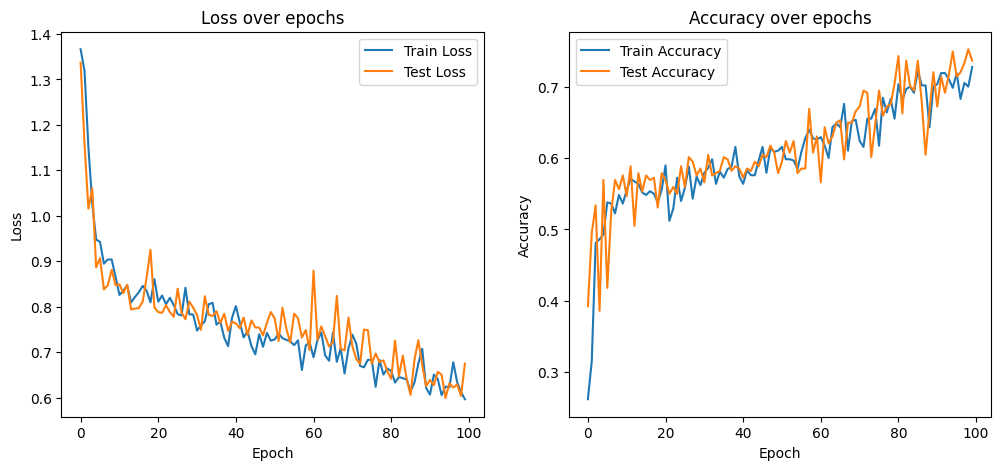

In [50]:
model = FoodFounder()
opt = torch.optim.Adam(model.parameters(), lr=0.0015)
loss_fn = nn.CrossEntropyLoss()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("🤖 Training on", device)
history = train(model, opt, loss_fn, train_loader, test_loader, epochs=100, device='cuda')

# Plotting loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['test_loss'], label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over epochs')

# Plotting accuracy
plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['test_acc'], label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy over epochs')

plt.show()


## K-Fold cross validation

In [51]:
def k_fold_cross_validation(model_class, dataset, optimizer_class, optimizer_params, num_folds=3, num_epochs=4, batch_size=16, device=None):
    if device is None:
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print("🤖 Training on", device)

    kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)
    fold_results = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(np.arange(len(dataset)))):
        print(f'\n🔀 Fold {fold+1}/{num_folds}')
        train_sampler = SubsetRandomSampler(train_idx)
        valid_sampler = SubsetRandomSampler(val_idx)
        train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler, num_workers=16, pin_memory=True)
        valid_loader = DataLoader(dataset, batch_size=batch_size, sampler=valid_sampler, num_workers=16, pin_memory=True)

        model = model_class().to(device)
        optimizer = optimizer_class(model.parameters(), **optimizer_params)
        loss_fn = nn.CrossEntropyLoss()

        for epoch in range(num_epochs):
            model.train()
            avg_train_loss = 0
            avg_test_loss = 0
            avg_train_acc = 0
            avg_test_acc = 0

            for images, labels in train_loader:
                images, labels = images.to(device), labels.to(device)
                optimizer.zero_grad()
                output = model(images)
                loss = loss_fn(output, labels)
                loss.backward()
                optimizer.step()
                avg_train_loss += loss.item()

                predicted = torch.argmax(nn.functional.softmax(output, dim=1), dim=1)
                train_correct_predictions = (predicted == labels).sum().item()
                avg_train_acc += train_correct_predictions / len(images)

            avg_train_loss /= len(train_loader)
            avg_train_acc /= len(train_loader)

            model.eval()
            with torch.no_grad():
                for images, labels in valid_loader:
                    images, labels = images.to(device), labels.to(device)
                    output = model(images)
                    loss = loss_fn(output, labels)
                    avg_test_loss += loss.item()

                    predicted = torch.argmax(nn.functional.softmax(output, dim=1), dim=1)
                    test_correct_predictions = (predicted == labels).sum().item()
                    avg_test_acc += test_correct_predictions / len(images)

            avg_test_loss /= len(valid_loader)
            avg_test_acc /= len(valid_loader)

            print(f"Summary for Fold {fold+1} - Epoch [{epoch+1}/{num_epochs}]:")
            print(f"\tTrain \tavg_loss: {avg_train_loss:.4f} \t| avg_acc: {avg_train_acc:.4f}")
            print(f"\tTest \tavg_loss: {avg_test_loss:.4f} \t| avg_acc: {avg_test_acc:.4f}")

        fold_results.append((avg_train_loss, avg_train_acc, avg_test_loss, avg_test_acc))

    avg_train_loss = sum([result[0] for result in fold_results]) / num_folds
    avg_train_acc = sum([result[1] for result in fold_results]) / num_folds
    avg_test_loss = sum([result[2] for result in fold_results]) / num_folds
    avg_test_acc = sum([result[3] for result in fold_results]) / num_folds

    print("\n🔎 K-Fold Cross Validation Results:")
    print(f"\tAverage Train Loss: {avg_train_loss:.4f}")
    print(f"\tAverage Train Accuracy: {avg_train_acc:.4f}")
    print(f"\tAverage Test Loss: {avg_test_loss:.4f}")
    print(f"\tAverage Test Accuracy: {avg_test_acc:.4f}")

    return fold_results, avg_train_loss, avg_train_acc, avg_test_loss, avg_test_acc

In [52]:
optimizer_params = {'lr': 0.001}
fold_results, avg_train_loss, avg_train_acc, avg_test_loss, avg_test_acc = k_fold_cross_validation(
    FoodFounder,
    train_dataset,
    torch.optim.Adam,
    optimizer_params,
    num_folds=2,
    num_epochs=2,
    batch_size=16
)

🤖 Training on cuda

🔀 Fold 1/2
Summary for Fold 1 - Epoch [1/2]:
	Train 	avg_loss: 1.3824 	| avg_acc: 0.2500
	Test 	avg_loss: 1.3601 	| avg_acc: 0.2138
Summary for Fold 1 - Epoch [2/2]:
	Train 	avg_loss: 1.3333 	| avg_acc: 0.3783
	Test 	avg_loss: 1.3268 	| avg_acc: 0.2895

🔀 Fold 2/2
Summary for Fold 2 - Epoch [1/2]:
	Train 	avg_loss: 1.3745 	| avg_acc: 0.2533
	Test 	avg_loss: 1.3554 	| avg_acc: 0.3257
Summary for Fold 2 - Epoch [2/2]:
	Train 	avg_loss: 1.3389 	| avg_acc: 0.3487
	Test 	avg_loss: 1.3553 	| avg_acc: 0.2763

🔎 K-Fold Cross Validation Results:
	Average Train Loss: 1.3361
	Average Train Accuracy: 0.3635
	Average Test Loss: 1.3411
	Average Test Accuracy: 0.2829


## Get Feature map

In [33]:
class FeatureExtractor(nn.Module):
    def __init__(self, model, target_layers):
        super(FeatureExtractor, self).__init__()

        self.model = copy.deepcopy(model)
        self.target_layers = target_layers
        self.features = []

        for layer_name, layer in self.model.named_modules():
            if layer_name in target_layers:
                layer.register_forward_hook(self.save_feature(layer_name))

    def save_feature(self, layer_name):
        def hook(module, input, output):
            self.features.append(output)
        return hook

    def forward(self, x):
        self.features = []
        self.model(x)
        return self.features

In [34]:
def visualize_feature_map(x,base_filename):
    out_dir = 'feature_map_result'
    os.makedirs(out_dir, exist_ok=True)
    x_channel_last = x[0].permute(1, 2, 0).cpu()

    num_channels = x_channel_last.size(2)

    num_rows = int(num_channels**0.5)
    num_cols = (num_channels // num_rows) + int(num_channels % num_rows > 0)

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(8, 8), subplot_kw={'xticks': [], 'yticks': []})
    for channel in range(num_channels):
        row = channel // num_cols
        col = channel % num_cols
        feat_m = x_channel_last[:, :, channel].detach().numpy()
        axes[row, col].imshow(feat_m, cmap='gray')
        axes[row, col].set_title(f'ch {channel + 1}\nrange: {feat_m.min(),feat_m.max()}',fontsize=7)


    base_filename = base_filename
    filename = f"{base_filename}.png"

    count = 1
    while os.path.exists(os.path.join(out_dir,filename)):
        filename = f"{base_filename}_{count}.png"
        count += 1
    fig.suptitle(filename.split('.')[0].split('/')[-1], fontsize=16)
    plt.tight_layout()
    plt.show()

In [35]:
layer_names = []
for layer_name, layer in model.named_modules():
    if layer_name == '':
        continue
    layer_names.append(layer_name)
print(layer_names)

['conv1', 'relu1', 'conv2', 'relu2', 'pool1', 'dropout1', 'conv3', 'relu3', 'pool2', 'dropout2', 'flatten', 'fc1', 'relu4', 'dropout3', 'fc2', 'relu5', 'dropout4', 'fc3']


torch.Size([1, 3, 64, 64])
label: FriedKale


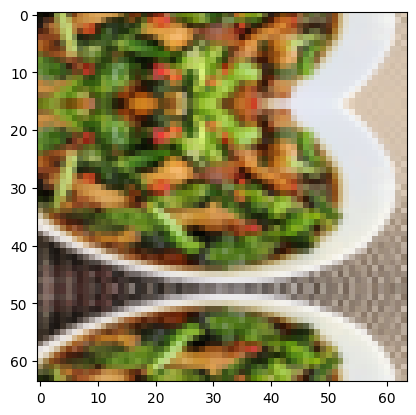

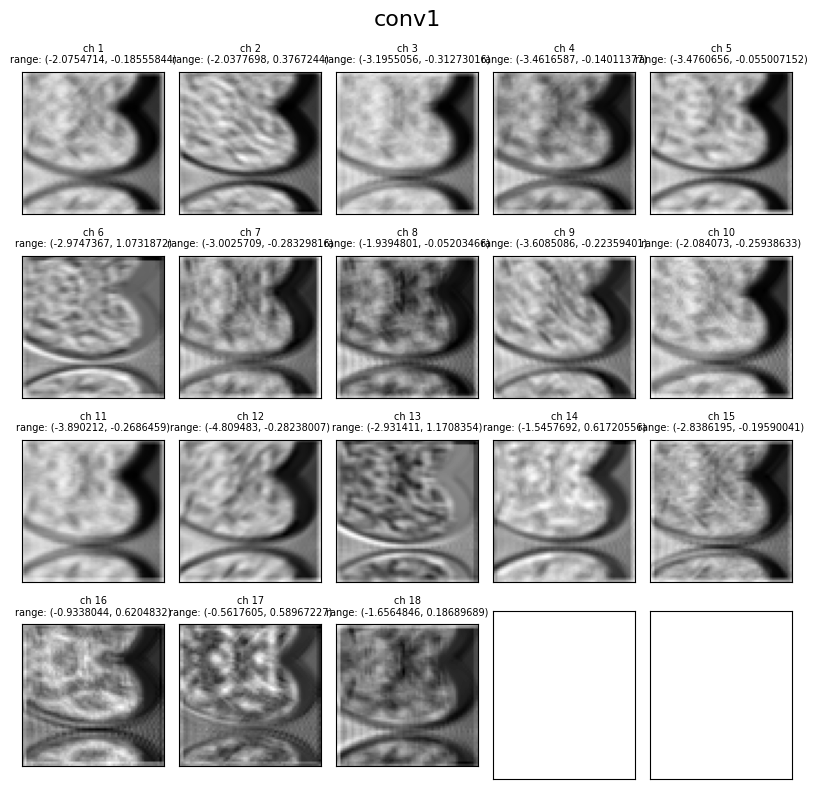

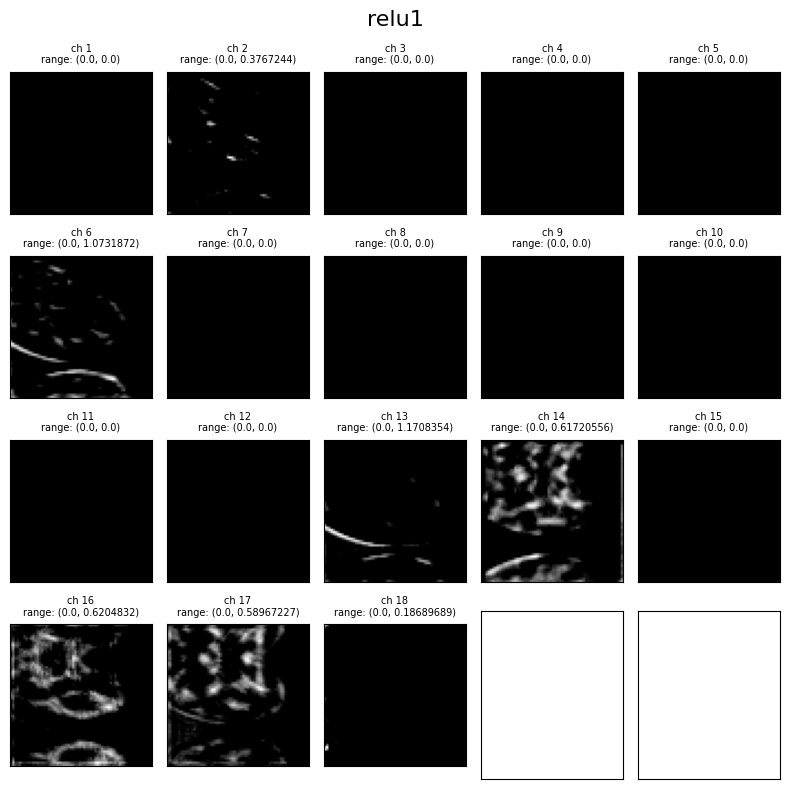

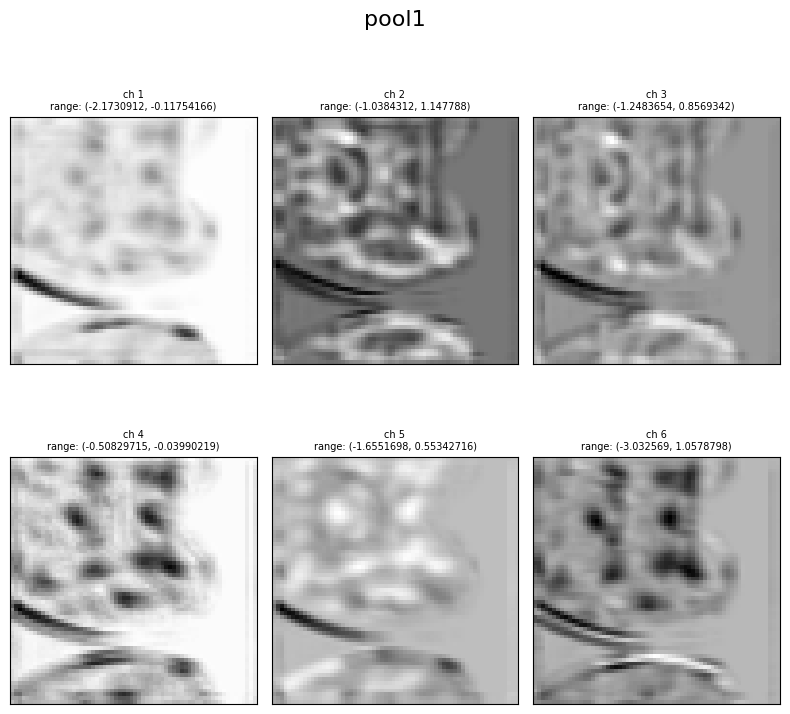

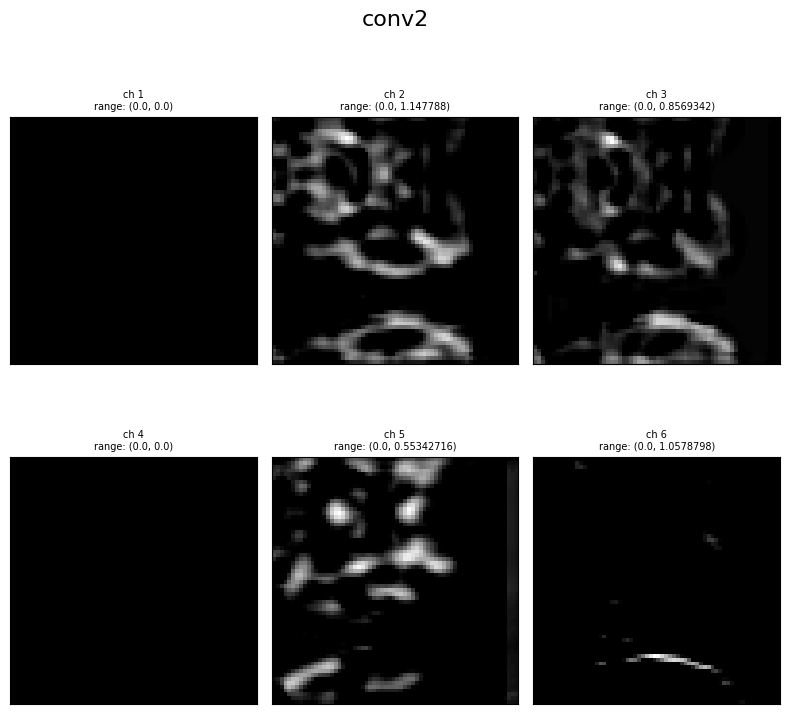

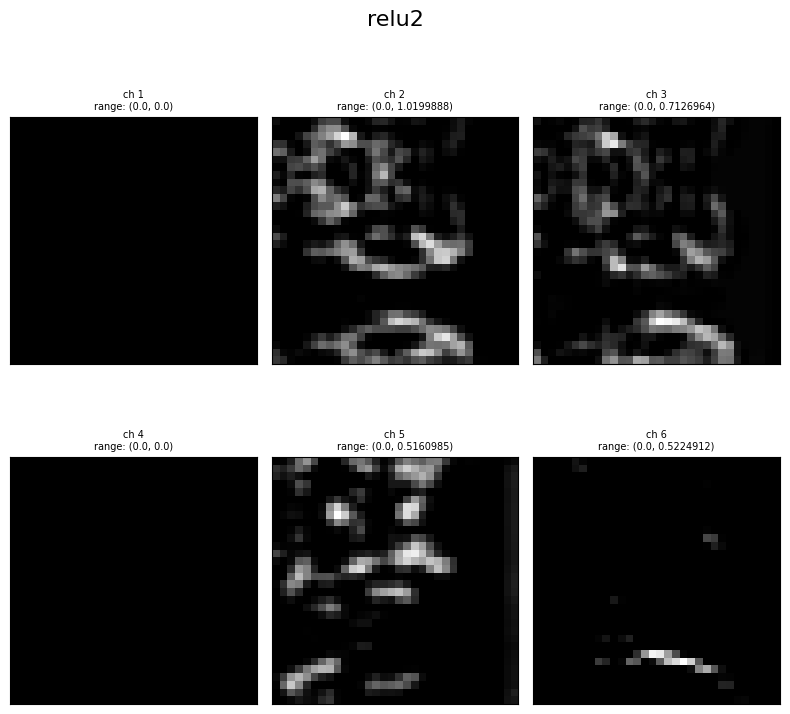

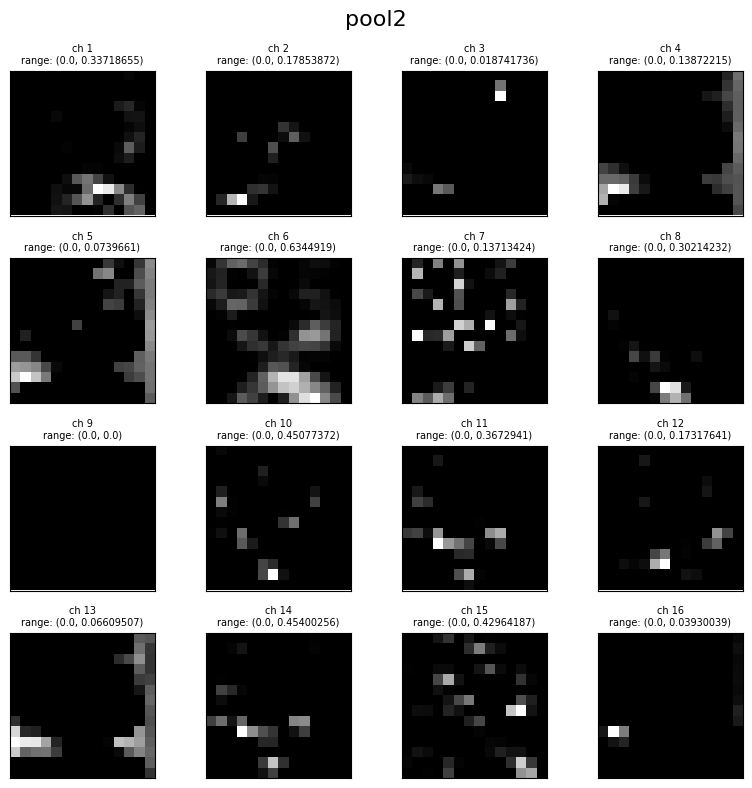

In [37]:

layer_names = ['conv1', 'relu1', 'pool1', 'conv2', 'relu2', 'pool2']
class_names = ['BooPadPongali', 'FriedKale', 'MassamanGai', 'PadPakBung']
batch, labels = next(iter(test_loader))

input_image = batch[0].unsqueeze(dim=0)
print(input_image.shape)
plt.imshow(input_image[0].permute(1, 2, 0))
print('label:',class_names[labels[0]])
feature_extractor = FeatureExtractor(model.eval(), layer_names)
feature_map = feature_extractor(input_image.to('cuda'))

for layer_name,feat in zip(layer_names,feature_map):
    visualize_feature_map(feat,layer_name)


# MODEL EVALUATION


In [38]:
def load_model(model,model_path):
    model.load_state_dict(torch.load(model_path))
    model.eval()
    return model

def plot_confusion_matrix(ax, cm, title, labels):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')

def summary_confusion_matrix(model, class_names):
    model = model.cuda()
    true_labels = []
    predicted_labels = []
    for images, labels in test_loader:
        images = images.cuda()
        labels = torch.tensor(labels)

        with torch.no_grad():
            output = model(images)
            predicted = output.argmax(dim=1).cpu().numpy()

        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted)

    true_labels = np.array(true_labels)
    predicted_labels = np.array(predicted_labels)
    report = classification_report(true_labels, predicted_labels, target_names=class_names)
    print(report)
    cm = confusion_matrix(true_labels, predicted_labels)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

<ipython-input-38-2becc8d7dae2>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


               precision    recall  f1-score   support

BooPadPongali       0.79      0.66      0.72        99
    FriedKale       0.82      0.73      0.78        94
  MassamanGai       0.67      0.83      0.75        72
   PadPakBung       0.62      0.76      0.69        46

     accuracy                           0.74       311
    macro avg       0.73      0.75      0.73       311
 weighted avg       0.75      0.74      0.74       311



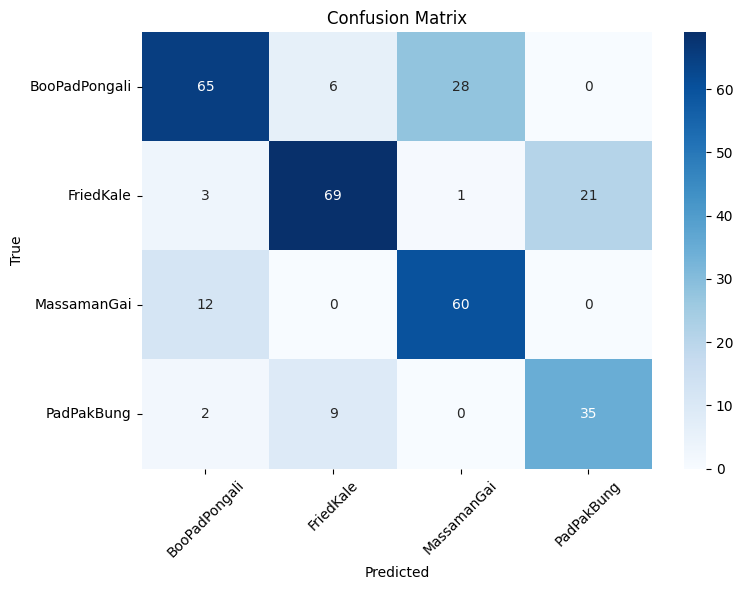

In [39]:
class_names = ['BooPadPongali', 'FriedKale', 'MassamanGai', 'PadPakBung']
summary_confusion_matrix(model, class_names)

In [40]:
model.state_dict()

OrderedDict([('conv1.weight',
              tensor([[[[-0.0468,  0.0065, -0.0167,  0.0590, -0.0658],
                        [ 0.0422, -0.0154, -0.0341, -0.0395, -0.0530],
                        [-0.0361, -0.0884, -0.0114, -0.0970, -0.1105],
                        [ 0.0498, -0.0937, -0.0847,  0.0209,  0.0846],
                        [-0.1008, -0.0212, -0.0373, -0.0158, -0.1165]],
              
                       [[-0.0509,  0.0170,  0.0764, -0.1162, -0.0269],
                        [-0.0233,  0.0527, -0.0774,  0.0018, -0.0334],
                        [-0.0501, -0.1011, -0.0684,  0.0539,  0.0553],
                        [-0.1008,  0.0451,  0.0447, -0.0971,  0.0227],
                        [ 0.0459,  0.0563, -0.0482, -0.1212,  0.0390]],
              
                       [[-0.0327,  0.0186, -0.0353, -0.1246,  0.0330],
                        [-0.0722, -0.1235,  0.0057, -0.0642, -0.0449],
                        [ 0.0579,  0.0700, -0.1163, -0.0932, -0.1082],
               

In [43]:
model.state_dict()['fc2.weight'].shape, model.state_dict()['fc2.bias'].shape

(torch.Size([84, 120]), torch.Size([84]))

In [42]:
save_path = "foodfounder.pth"
torch.save(model.state_dict(), save_path)

---

# Exercise

ให้ทดลองปรับพารามิเตอร์ต่อไปนี้ แล้วเขียนอธิบายว่าทำอะไรเพิ่มเติม และมีการเปลี่ยนแปลงอะไรเกิดขึ้นบ้าง
1. LENET Model Architecture (เช่น node, layer, etc.)
2. training parameters (เช่น learning rate, optimizer, batch_size, etc.)

เพื่อให้ได้ Loss ต่ำที่สุด และ สามารถทำ Data Augment เพิ่มเติมได้หากจำเป็น
กำหนดให้ใช้ Performance metrics เป็น F1-Score

***สิ่งที่ต้องส่ง***
1. ผลการทดสอบโมเดลกับ **Test dataset**\* ที่กำหนดเป็นไฟล์ `.csv` ประกอบไปด้วย 2 คอลัมน์ ([ตัวอย่างไฟล์ csv](https://github.com/NextGen-AI-Camp/curriculum/blob/main/Week%235/CNN%232/sample_submission.csv))
    - คอลัมน์ที่่ 1 เป็นชื่อไฟล์รูปที่ใช้ predict
    - คอลัมน์ที่ 2 เป็นผลัพธ์การ predict จากโมเดล

2. ไฟล์ weight ของโมเดล (`.pth` หรือ `.pt`)
3. ไฟล์ source code (`.ipynb`)

***กรุณาส่งไฟล์ดังนี้:***
- ไฟล์ `.csv` แยกต่างหาก
- ไฟล์ `.zip` ที่ zip ไฟล์ weight ของโมเดล (`.pth` หรือ `.pt`) และไฟล์ source code (`.ipynb`)

***\*Note: Test dataset จะเปิด public วันศุกร์ที่ 2 สค. เวลา 22.00 น.***